![Building](building.svg)

![Cricuit](therm_circ.svg)

In [361]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import dm4bem
# from dm4bem import read_epw, sol_rad_tilt_surf

In [362]:
lenght = 5                                   # length of the cubic room     [m]
width = 3                                    # widht of room                [m]
hight = 3                                    # room hight                   [m]
window_hight = 1.5                             # hight of Window              [m]
hight_wall  =   hight-window_hight           # hight of outside wall        [m]

S_window = width * window_hight              # surface area of the window   [m²]
S_wall_c = S_wall_i = width * hight_wall     # surface area of concrete & insulation  outside wall       [m²]
S_ceiling = lenght * width                   # surface area of ceiling      [m²]

w_wall_i = 0.1          # thickness of insulation wall   [m]
w_wall_c = 0.2          # thickness of concrete wall     [m]
w_ceiling_c = 0.33      # thickness concrete cyling      [m]

V_room = width * lenght *hight # volme of the room       [m³]

# heat transfer coefficient
h_o = 25     # convection coefficient outdoor       [W/(m²⋅K)]
h_i = 8      # convection coefficient indoor        [W/(m²⋅K)]


# Thermo-physical properties air
ρ_air = 1.2     # density air       [kg/m³]
c_air = 1000    # specific heat     [J/(kg·K)]

# Thermo-physical properties water
c_w = 4187    # specific heat     [J/(kg·K)]


# Thermo-physical properties concrete
λ_concrete = 1.400      # thermal conductivity concrete      [W/(m·K)]
ρ_concrete = 2300.0     # density concrete                   [kg/m³]
c_concrete = 880        # specific heat concrete             [J/(kg⋅K)]


# Thermo-physical properties insulation
λ_insulation = 0.027      # thermal conductivity insulation      [W/(m·K)]
ρ_insulation = 55.0       # density insulation                   [kg/m³]
c_insulation = 1210       # specific heat insulation             [J/(kg⋅K)]

# Thermo-physical properties window
U_window = 1.00     # U-value of the window     [W/(m²·K)]

In [363]:
# Temperatures
T_0 = -10         # Temperature outdoor           [°C]
T_i_sp = 22     # temperature indoor setpoint   [°C]

*The outdoor temperture $T_o$ will be from the weatherdata*

In [364]:
# P-controller gain
kp = 1e4

In [365]:
ACH = 0.3       # air changes per hour  [1/h]

U-value window: $U_W = 1.0 \quad \left[ \frac{W}{m^2 K}\right]$

In [366]:
α = 0       # absorbtion of outdoor surace
E = 400     # irradiance [W/m²]

Q̇_sol =  α * E * S_wall_i       # solar iradiation on outdoor wall [W]

In [367]:
Q̇_a = 0    # auxiliary heat gains      [W]


In [368]:
ṁ = 160 # massflow [kg/h]
ΔT = 4  # temperature difference flow and return [K]
ṁ = 8

Q̇_HVAC = ṁ * c_w * ΔT / 3600 # [W]
Q̇_HVAC

37.217777777777776

## Read Weather data
The weather data for Luzern will be read for the outdoor temperature and the solar irradiation.

In [369]:
# read wheater data
filename = './weatherdata/CHE_LU_Luzern.066500_TMYx.2009-2023.epw'

[data, meta] = dm4bem.read_epw(filename, coerce_year=None)

# Extract the month and year from the DataFrame index with the format 'MM-YYYY'
month_year = data.index.strftime('%m-%Y')

# Create a set of unique month-year combinations
unique_month_years = sorted(set(month_year))

# Create a DataFrame from the unique month-year combinations
pd.DataFrame(unique_month_years, columns=['Month-Year'])

,Month-Year
0,01-2013
1,02-2011
2,03-2020
3,04-2022
4,05-2023
5,06-2018
6,07-2016
7,08-2019
8,09-2019
9,10-2012


In [370]:
# select columns of interest
weather_data = data[["temp_air", "dir_n_rad", "dif_h_rad"]]

# replace year with 2000 in the index 
weather_data.index = weather_data.index.map(
    lambda t: t.replace(year=2000))

In [371]:
weather_data.loc['2000-06-29 12:00']

temp_air      22.7
dir_n_rad    281.0
dif_h_rad    297.0
Name: 2000-06-29 12:00:00+01:00, dtype: float64

Start and end time

In [372]:
# Define start and end dates
start_date = '2000-01-05'
end_date = '2000-01-08'         # time is 00:00 if not indicated

# Filter the data based on the start and end dates
weather_data = weather_data.loc[start_date:end_date]
del data
weather_data

,temp_air,dir_n_rad,dif_h_rad
2000-01-05 00:00:00+01:00,5.7,0,0
2000-01-05 01:00:00+01:00,5.5,0,0
2000-01-05 02:00:00+01:00,5.3,0,0
2000-01-05 03:00:00+01:00,4.1,0,0
2000-01-05 04:00:00+01:00,5.4,0,0
...,...,...,...
2000-01-08 19:00:00+01:00,2.7,0,0
2000-01-08 20:00:00+01:00,2.7,0,0
2000-01-08 21:00:00+01:00,2.6,0,0
2000-01-08 22:00:00+01:00,2.4,0,0


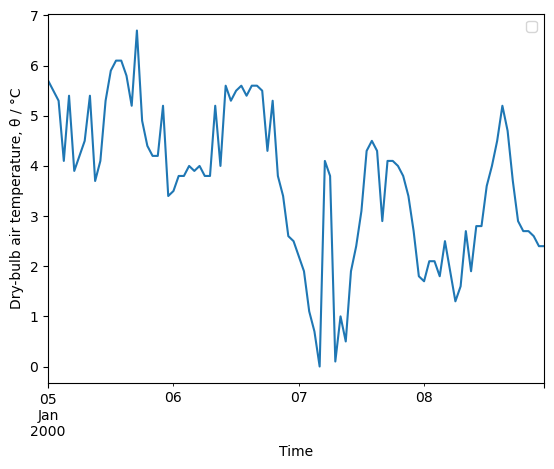

In [373]:
weather_data['temp_air'].plot()
plt.xlabel("Time")
plt.ylabel("Dry-bulb air temperature, θ / °C")
plt.legend([])
plt.show()

*precisise solar iradience --> from weatherdata*

## A: incidence matrix

In [374]:
# incidence matrix
A = np.zeros([12, 11]) # n° of branches X n° of nodes
A[0, 0] = 1
A[1, 0], A[1, 1] = -1, 1
A[2, 1], A[2, 2] = -1, 1
A[3, 2], A[3, 3] = -1, 1
A[4, 3], A[4, 4] = -1, 1
A[5, 4], A[5, 7] = -1, 1
A[6, 5], A[6, 6] = -1, 1
A[7, 8], A[7, 7] = -1, 1
A[8, 9], A[8, 8] = -1, 1
A[9, 10], A[9, 9] = -1, 1
A[10, 7] = 1
A[11, 7] = 1

A

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.]])

## G: conductance matrix

In [375]:
# conductance matrix
G = np.array([h_o * S_wall_i,                               # convection outdor wall
              λ_insulation / w_wall_i * S_wall_i * 2,       # conduction insulation
              λ_insulation / w_wall_i * S_wall_i * 2,       # conduction insulation
              λ_concrete / w_wall_c * S_wall_c * 2,         # conduction concrete
              λ_concrete / w_wall_c * S_wall_c * 2,         # conduction concrete
              h_i * S_wall_c,                               # convection indoor wall
              U_window * S_window,                          # Convection and conduction window
              h_i * S_ceiling,                              # convection ceiling
              λ_concrete / w_ceiling_c * S_ceiling * 2,     # conduction ceiling
              λ_concrete / w_ceiling_c * S_ceiling * 2,     # conduction ceiling
              ACH * V_room / 3600*ρ_air*c_air,              # advection ventilation
              kp                                            # kontroller gain
              ])
G = np.diag(G)
G

array([[1.12500000e+02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.43000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.43000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.30000000e+01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        6.30000000e+01, 0.00000000e+00, 0.00000000e+00, 0.00

## b: temperature source vector 

In [376]:
# temperature source vector
b = np.zeros(12)
b[0] = T_0
b[6] = T_0
b[10] = T_0
b[11] = T_i_sp

b




array([-10.,   0.,   0.,   0.,   0.,   0., -10.,   0.,   0.,   0., -10.,
        22.])

## f: heat flow source vector

In [377]:
# flow source vector
f = np.zeros(11)
f[0] = Q̇_sol
f[7] = Q̇_a
f[10] = Q̇_HVAC



In [378]:
θ = np.linalg.pinv(A.T @ G @ A) @ (A.T @ G @ b + f)
q = G  @ (-A @ θ + b)

 
q


array([-3.58802562e+01, -3.58802562e+01, -3.58802562e+01, -3.58802562e+01,
       -3.58802562e+01, -3.58802562e+01, -7.99360578e-13,  3.72177778e+01,
        3.72177778e+01,  3.72177778e+01, -1.43935831e+02,  1.42598309e+02])

In [379]:
q_S = q[11]/S_ceiling
print(f"q = {q[11]:.1f} W")
print(q[7])


q = 142.6 W
37.21777777777561


In [381]:
q_S

9.506553942619197

to do:
- prediction controller --> non linear controller
- wheater data
    - use weather data as imput for temperature and radiation
- test with steady stat
    - dynamic
    

## References

1. [EnFK (2021)](https://www.endk.ch/de/ablage/ftw-simplelayout-filelistingblock/Merkblatt_Fenster_D_2021.pdf/view). Merkblatt Fenster
